# Melbourne Housing Project

## 1. Objective: Create a model (Linear Regression) to predict a house's value

    1. Dataset: [Melbourne Housing Market](https://www.kaggle.com/anthonypino/melbourne-housing-market)
    
    2. Some details about the features:
   - Suburb: Suburb
   - Address: Address
   - Rooms: Number of rooms
   - Price: Price in Australian dollars
   - Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior notdisclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

- Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

- SellerG: Real Estate Agent

- Date: Date sold

- Distance: Distance from CBD in Kilometres

- Regionname: General Region (West, North West, North, North east ...etc)

- Propertycount: Number of properties that exist in the suburb.

- Bedroom2 : Scraped # of Bedrooms (from different source)

- Bathroom: Number of Bathrooms
 
- Car: Number of carspots

- Landsize: Land Size in Metres

- BuildingArea: Building Size in Metres

- YearBuilt: Year the house was built

- CouncilArea: Governing council for the area

- Lattitude: Self explanitory

- Longtitude: Self explanitory

## 2. Steps / guideline:
1. [x] Examine and explore data (visualization, interactions among features)
2. [x] Apply the model for prediction with holdout and cross validation
3. [x] Using PCA, apply the model with holdout and cross validation
4. [x] Visualize the residue and homoscedascity
5. [x] Tune the model if neccessary
6. [x] Write up analysis for each section (e.g: explain why the model is overfitting, explain why applying PCA is better, etc.)
7. [x] Include conclusions for summary

# Conclusions

1. k-Fold helps us reduce the "bias" of an evaluation. Instead of selecting training set / validation set randomly, we split the training set into k "fold" and our final "accuraccy" (or something like this) will be the mean of the evaluations of these k folds.

2. The metrics really change how the model "penalize" errors. I.e. RMSE / MAE will penalize large error more robust than MAPE, MAPE and MAE wil more robust to outliers, MPE tells us if there is more positive errors than negative errors or not. For easily telling how good a regression model is, we could simply use R2_score or modified R2_score.

3. With categorical features that have more than 50 unique values, we should consider using PCA because one-hot-coding them may cause our data being "stretched" (got too much features).

3. PCA helps training / validating phases much more faster.

4. The better feature engineering, the better result.

5. Linear Regression coefficients could tell us how much a numeric features affect to the target, not on the categorical features

#### Import libraries and some tweaks

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%matplotlib inline
plt.style.use('seaborn-white')

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


#### We'll use the Full version Melbourne housing dataset

In [3]:
data = pd.read_csv("./melbourne-housing-market/Melbourne_housing_FULL.csv")
print(data.shape)
data.head( )

(34857, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


34k records is quite enough for a univariate regression task isnt it? Let's dive more to understand the data

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

first_day = data.iloc[0].Date
data['count_date'] = pd.to_datetime(data['Date']) - pd.to_datetime(first_day)
data['count_date'] = data['count_date'].dt.days.astype('int16')

We could see Date feature here as a "categorical feature", so we need to convert it to numeric values by counting the date since the oldest record

In [5]:
count_nan = data.isnull().sum(axis=0) 
percentage_nan = count_nan / data.shape[0] * 100
print(percentage_nan)
data.describe(percentiles=[.25,.5,.75,.95,.997])


Suburb            0.000000
Address           0.000000
Rooms             0.000000
Type              0.000000
Price            21.832057
Method            0.000000
SellerG           0.000000
Date              0.000000
Distance          0.002869
Postcode          0.002869
Bedroom2         23.573457
Bathroom         23.599277
Car              25.039447
Landsize         33.881286
BuildingArea     60.576068
YearBuilt        55.386293
CouncilArea       0.008607
Lattitude        22.882061
Longtitude       22.882061
Regionname        0.008607
Propertycount     0.008607
count_date        0.000000
dtype: float64


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,count_date
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000,34857.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306,475.367358
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313,223.111856
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000,0.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000,261.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000,513.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000,639.000000
95%,5.000000,2.250000e+06,24.700000,3204.000000,5.000000,3.000000,4.000000,1001.000000,310.00000,2013.000000,-37.675190,145.187700,15510.000000,779.000000
99.7%,6.000000,4.600000e+06,41.000000,3806.000000,6.000000,5.000000,6.000000,7457.586000,697.00000,2017.000000,-37.564710,145.337767,21650.000000,979.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000,979.000000


There are 2 columns have more than 50% of data points is null: **YearBuilt** and **BuildingArea**, so basically we'll have to remove them

In [6]:
data.describe(include='O')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,33,8
top,Reservoir,5 Charles St,h,S,Jellis,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,3675,11836


With the columns which have the *object* data type, we will use 4 of them with **one-hot-coding** method: **Type, Method, CouncilArea, Regionname** because they all have less than 50 unique values (the more unique values, the more columns need to be used to encode)

In [7]:
for col in data.columns:
    if percentage_nan[col] >= 50:
        data = data.drop(col, axis=1)

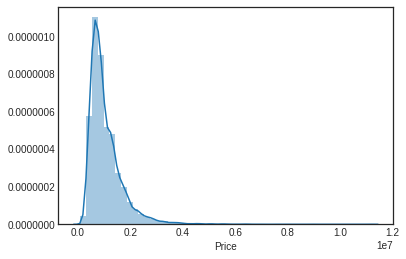

In [8]:
sns.distplot(data['Price'].dropna())

The House Price distribution seems like log-distribution

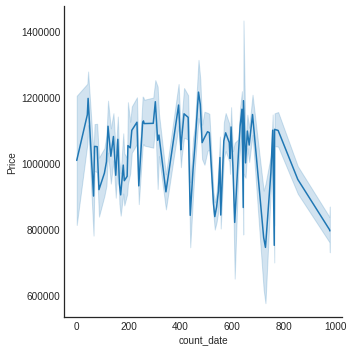

In [9]:
sns.relplot(x='count_date', y='Price', data=data, kind='line')

Quick check whether the **Price** depends on the **count_date** feature or not, there's no clear insight here

In [10]:
data.corr()[(data.corr() >= 0.8) & (data.corr() != 1.0)]

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,count_date
Rooms,NaN,NaN,NaN,NaN,0.946755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Postcode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bedroom2,0.946755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bathroom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Landsize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lattitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Longtitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the columns that have correlation coefficients >= 0.8 to prevent **colinearity effect** 

In [11]:
data = data.drop(['Bedroom2'], axis=1)

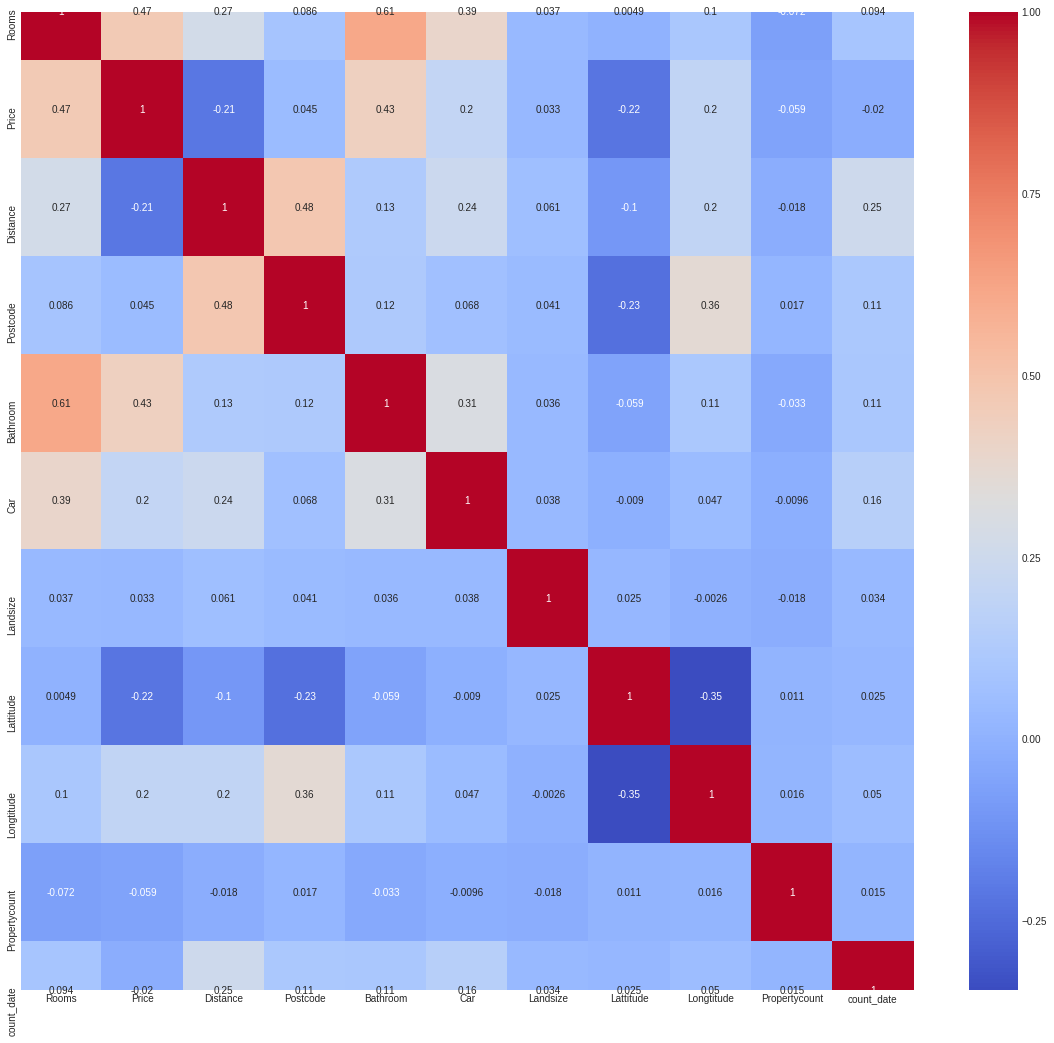

In [12]:
corr = data.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='coolwarm')

The correlation matrix give us 4 columns that need to have more *attention*: **Rooms, Bathroom, Distance, Lattitude**

In [13]:
pd.Series(data.dtypes=='float64')[pd.Series(data.dtypes=='object')==False].index


Index(['Rooms', 'Price', 'Date', 'Distance', 'Postcode', 'Bathroom', 'Car',
       'Landsize', 'Lattitude', 'Longtitude', 'Propertycount', 'count_date'],
      dtype='object')

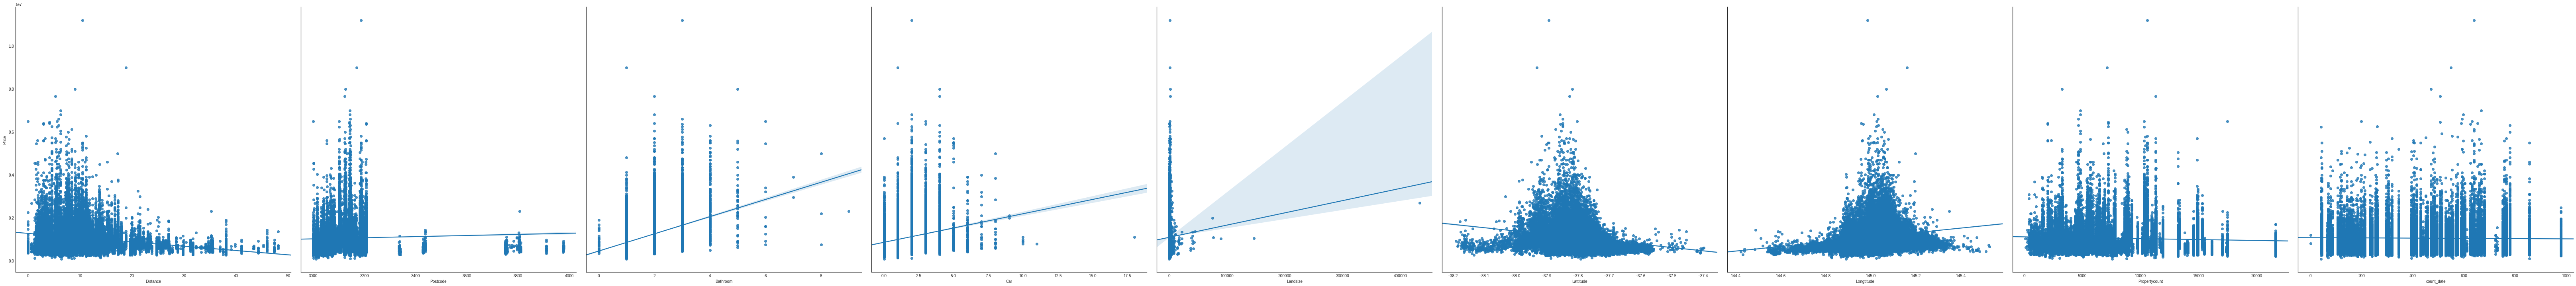

In [14]:
sns.pairplot(data=data, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price'], kind='reg', size=10)

In these features: 'Bathroom', 'Car', 'Landsize', we can see that there is a line that could fit in to these features & Price. In the Landsize fit line, there is a huge gap of **heteroskedasticity**, we will figure out why in categorical features.

In [15]:
data.describe(include='O')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,33,8
top,Reservoir,5 Charles St,h,S,Jellis,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,3675,11836


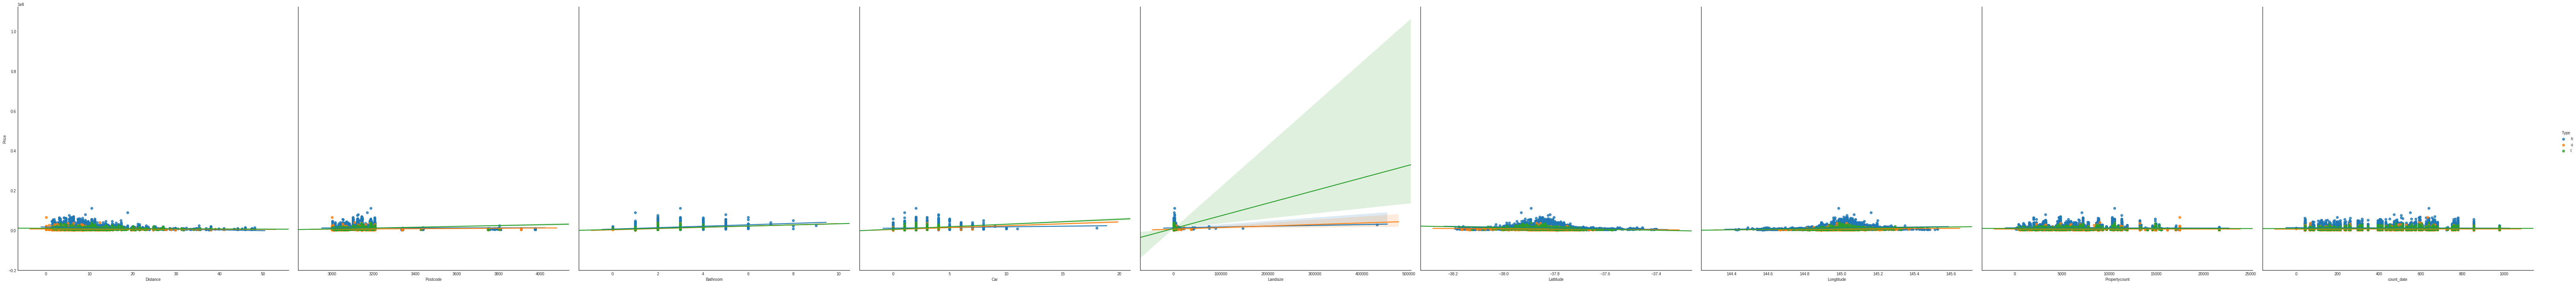

In [16]:

sns.pairplot(data=data, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price'], hue='Type', kind='reg', size=10)

With feature **Type**, there is no difference between the values of it, except the **Landsize** 

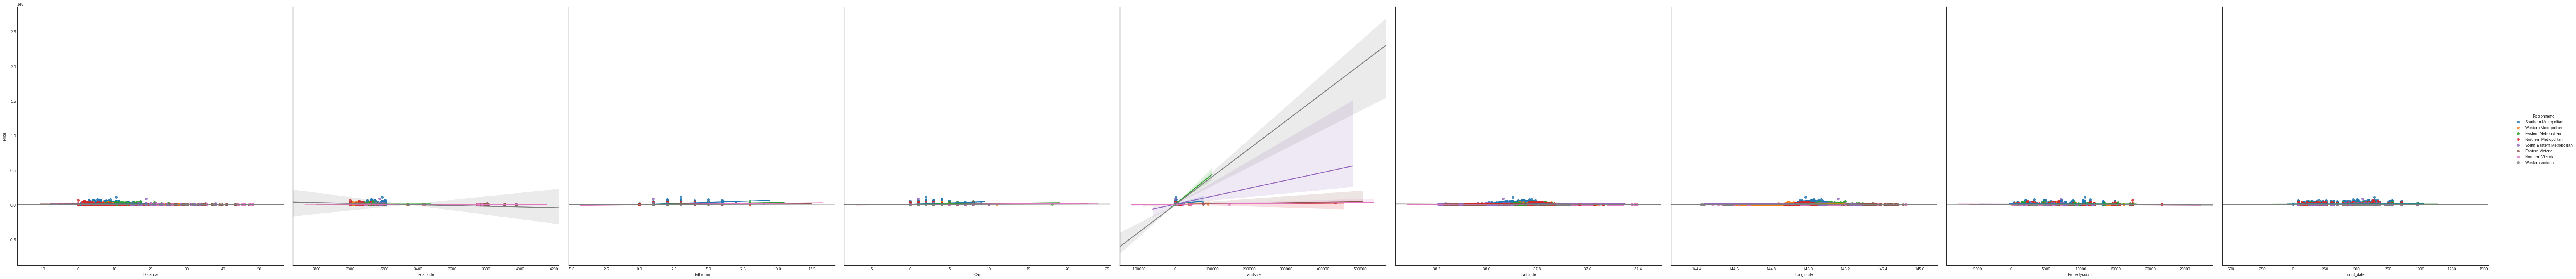

In [17]:

sns.pairplot(data=data, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price'], hue='Regionname', kind='reg', size=10)

The difference in the **Landsize** is described pretty clear here. That's the difference in the **Regionname**

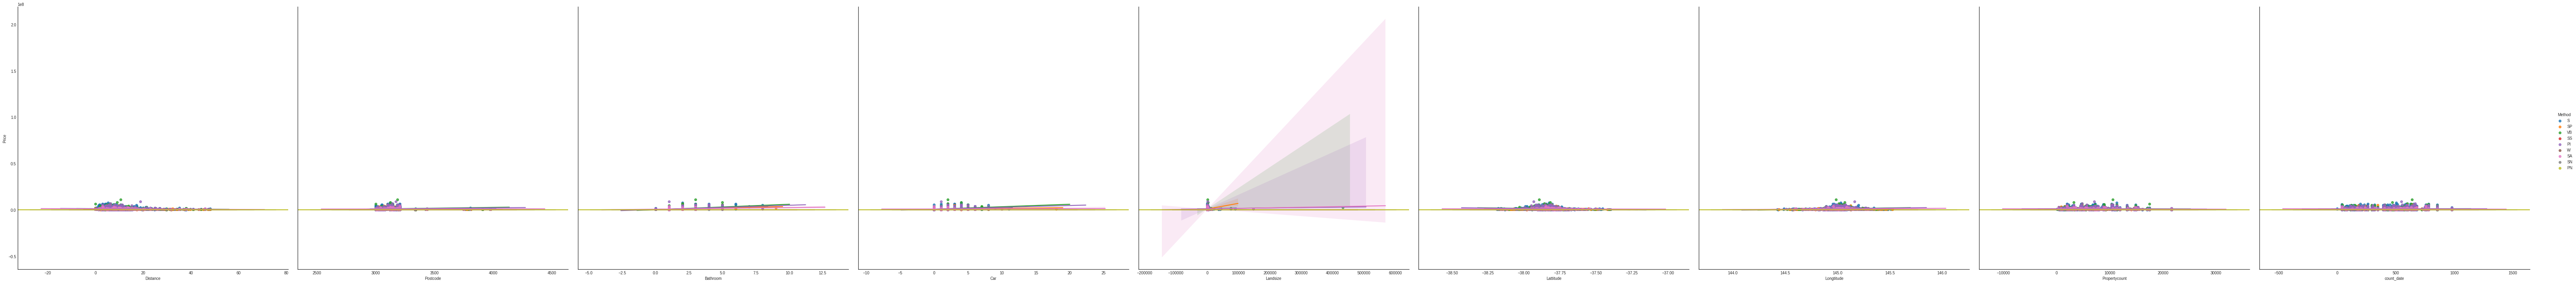

In [18]:

sns.pairplot(data=data, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price'], hue='Method', kind='reg', size=10)

There is no clear insight, the values **Method** don't impact much to the **Price**

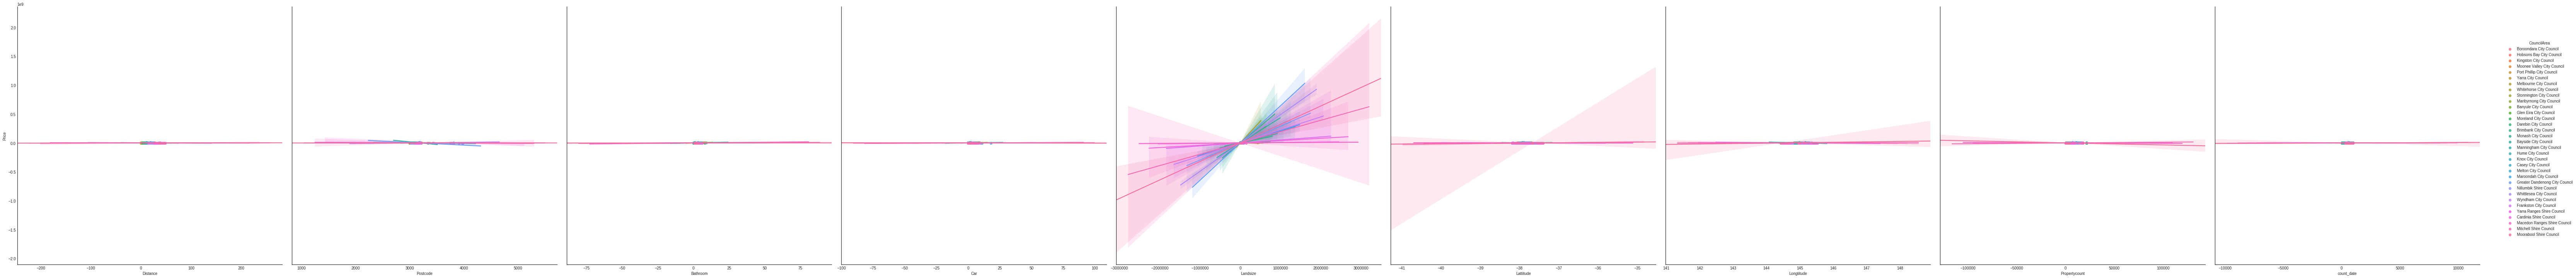

In [19]:

sns.pairplot(data=data, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price'], hue='CouncilArea', kind='reg', size=10)

Once again, we can see that the line between **Price and Landsize** affected by a categorical feature, that's **CouncilArea**

## Linear Regression with Holdout


In [135]:
data.describe(include='O')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,33,8
top,Reservoir,5 Charles St,h,S,Jellis,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,3675,11836


In [136]:
data.select_dtypes(exclude='object').columns.to_list()

['Rooms',
 'Price',
 'Date',
 'Distance',
 'Postcode',
 'Bathroom',
 'Car',
 'Landsize',
 'Lattitude',
 'Longtitude',
 'Propertycount',
 'count_date']

Because we removed some *useless* features, now we will use all numeric values to get the regression

In [137]:
# numeric_cols = ['Price', 'Rooms', 'Lattitude', 'count_date', 'Longtitude', 'Propertycount', 'Distance', 'Bathroom', 'Car', 'Landsize']
numeric_cols = ['Rooms',
                'Price',
                'Distance',
                'Postcode',
                'Bathroom',
                'Car',
                'Landsize',
                'Lattitude',
                'Longtitude',
                'Propertycount',
                'count_date']
categorical_cols = ['Type', 'Regionname', 'CouncilArea', 'Method']
cols = numeric_cols + categorical_cols

Why choose 4 categorical columns above? Because they don't have much unique values, that means we don't have to "spread" our data too much

In [138]:
train_df = data[cols]
train_df = train_df[train_df['Price'] >0]
print(train_df.shape)

(27247, 15)


In [139]:
# One-hot-encoding the categorical features
train_df = pd.get_dummies(train_df, prefix=categorical_cols, dummy_na=False)

In [140]:
y = train_df[['Price']]
X = train_df.drop('Price', axis=1)

In [141]:
print(X.shape)
X.head()

(27247, 59)


,Rooms,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,count_date,Type_h,Type_t,Type_u,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Method_PI,Method_S,Method_SA,Method_SP,Method_VB
10128,3,11.2,3127.0,1.0,2.0,490.0,-37.8361,145.1006,5457.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10127,2,11.2,3127.0,1.0,2.0,108.0,-37.8276,145.1023,5457.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10637,3,8.0,3016.0,1.0,1.0,507.0,-37.8681,144.8994,6380.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7020,3,8.4,3015.0,1.0,2.0,281.0,-37.8457,144.8651,5498.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7019,3,8.4,3015.0,2.0,2.0,301.0,-37.8420,144.8902,5498.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [142]:
y.head()

,Price
10128,1205000.0
10127,813000.0
10637,1535000.0
7020,826000.0
7019,1025000.0


In [143]:
# Fill all missing values in training data to the mean of each column
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imp.fit_transform(X)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [144]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

y = min_max_scaler.fit_transform(y)


# Train, test, split with Train/Test rate = 0.8/0.2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=1109)



In [30]:
# Fit the Linear Regression Model to the training data
from sklearn.linear_model import LinearRegression

# Create linear regression object
regressor = LinearRegression(normalize=False)


# Fit model to training data
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
y_pred = regressor.predict(X_test)


In [32]:
# Score It
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))


MAE: 0.023246884794038396
MSE: 0.0012213194830919959
RMSE: 0.03494738163427978
R^2 = 0.6273064350015674


# Linear Regression k-Fold

In [145]:
# numeric_cols = ['Price', 'Rooms', 'Lattitude', 'count_date', 'Longtitude', 'Propertycount', 'Distance', 'Bathroom', 'Car', 'Landsize']
numeric_cols = ['Rooms',
                'Price',
                'Distance',
                'Postcode',
                'Bathroom',
                'Car',
                'Landsize',
                'Lattitude',
                'Longtitude',
                'Propertycount',
                'count_date']
categorical_cols = ['Type', 'Regionname', 'CouncilArea', 'Method']
cols = numeric_cols + categorical_cols

In [146]:
train_df = data[cols]
# train_df
train_df = train_df[train_df['Price'] >0]
print(train_df.shape)

(27247, 15)


In [147]:
# train_df['Regionname'].describe()

In [148]:
train_df = pd.get_dummies(train_df[cols], prefix=categorical_cols, dummy_na=False)

In [149]:
y = train_df[['Price']]
X = train_df.drop('Price', axis=1)

In [150]:
print(train_df.shape)
X.head()

(27247, 60)


,Rooms,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,count_date,Type_h,Type_t,Type_u,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Method_PI,Method_S,Method_SA,Method_SP,Method_VB
10128,3,11.2,3127.0,1.0,2.0,490.0,-37.8361,145.1006,5457.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10127,2,11.2,3127.0,1.0,2.0,108.0,-37.8276,145.1023,5457.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10637,3,8.0,3016.0,1.0,1.0,507.0,-37.8681,144.8994,6380.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7020,3,8.4,3015.0,1.0,2.0,281.0,-37.8457,144.8651,5498.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7019,3,8.4,3015.0,2.0,2.0,301.0,-37.8420,144.8902,5498.0,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [151]:
y.head()

,Price
10128,1205000.0
10127,813000.0
10637,1535000.0
7020,826000.0
7019,1025000.0


In [152]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imp.fit_transform(X)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [153]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = min_max_scaler.fit_transform(y)


In [42]:
# Train, test, split using k-fold with k=10
from sklearn.model_selection import KFold
# Fit
# Import model
from sklearn.linear_model import LinearRegression

# Create linear regression object
# regressor = LinearRegression(normalize=True)
regressor = LinearRegression(normalize=False)

scores = []
import time
start_time = time.time()
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))

print(np.mean(scores))
stop_time = time.time()
print(stop_time - start_time)


0.6033922712612045
1.5328192710876465


> To summarize, there is a bias-variance trade-off associated with the choice of k in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance

    With R2_score = 0.6 for a house-prediction task is no so good for a linear regression solution. We will use some other techniques like PCA to find out whether an improvement here or not

# PCA 

There are many features, so I am going to use PCA to reduce them. The idea is to start with n_components = number of columns. Then select the number of components that add up to 1 variance_ratio.



In [43]:
from sklearn.decomposition import PCA


In [44]:
pca = PCA(whiten=True)
pca.fit(X)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)


array([0.14364377, 0.26013096, 0.36694112, 0.45790726, 0.51766123,
       0.5649002 , 0.60740079, 0.64413731, 0.67415862, 0.70234495,
       0.72881074, 0.74866749, 0.76801763, 0.78658118, 0.80505379,
       0.82213157, 0.83832179, 0.85262823, 0.86662053, 0.87942998,
       0.89161235, 0.90347523, 0.91497899, 0.92586786, 0.93626172,
       0.94415693, 0.95062823, 0.95683541, 0.96193116, 0.96673399,
       0.9706249 , 0.97446379, 0.97750076, 0.98040621, 0.98302839,
       0.98549699, 0.98766104, 0.98964508, 0.9914883 , 0.99275324,
       0.99390804, 0.99492127, 0.9957803 , 0.99650393, 0.99711345,
       0.99770153, 0.99825473, 0.99871971, 0.99912725, 0.99945243,
       0.99968101, 0.99982258, 0.99991952, 0.99997725, 0.99999414,
       1.        , 1.        , 1.        , 1.        ])

In [45]:
pca = PCA(n_components=56,whiten=True)
pca = pca.fit(X)
dataPCA = pca.transform(X)

## PCA -> Linear Regression with Holdout

In [46]:
# Train, test, split with Train/Test rate = 0.8/0.2
X_train, X_test, y_train, y_test = train_test_split(dataPCA,y, test_size=.20, random_state=1109)

# Create linear regression object
regressor = LinearRegression(normalize=False)


# Fit model to training data
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
y_pred = regressor.predict(X_test)


In [48]:
# Score It
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))


MAE: 0.023249347575207545
MSE: 0.0012214434407428617
RMSE: 0.034949155079098286
R^2 = 0.6272808755390928


## PCA -> Linear Regression with k-fold

In [49]:
# Create linear regression object
# regressor = LinearRegression(normalize=True)
regressor = LinearRegression(normalize=False)

scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)

start_time = time.time()


for train_index, test_index in cv.split(dataPCA):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))

print(np.mean(scores))

stop_time = time.time()
print(stop_time - start_time)


0.6033922712612045
1.3466558456420898


> There is no increase in R2-score after applying PCA. But it makes the learning and testing phases much faster
> I think the reason is our no. of features is kind of small, we will take more categorical features -> get much more features to figure out whether PCA helps us increase the regression score or not

# Linear Regression k-Fold and PCA with larger number of features

In [50]:
data.describe(include='O')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,33,8
top,Reservoir,5 Charles St,h,S,Jellis,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,3675,11836


In [51]:
# numeric_cols = ['Price', 'Rooms', 'Lattitude', 'count_date', 'Longtitude', 'Propertycount', 'Distance', 'Bathroom', 'Car', 'Landsize']
numeric_cols = ['Rooms',
                'Price',
                'Distance',
                'Postcode',
                'Bathroom',
                'Car',
                'Landsize',
                'Lattitude',
                'Longtitude',
                'Propertycount',
                'count_date']
categorical_cols = ['Type', 'Regionname', 'CouncilArea', 'Method', 'Suburb']
cols = numeric_cols + categorical_cols

In [52]:
train_df = data[cols]
# train_df
train_df = train_df[train_df['Price'] >0]
print(train_df.shape)

(27247, 16)


In [53]:
train_df = pd.get_dummies(train_df[cols], prefix=categorical_cols, dummy_na=False)

In [54]:
y = train_df[['Price']]
X = train_df.drop('Price', axis=1)

In [55]:
print(train_df.shape)
X.head()

(27247, 405)


,Rooms,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,count_date,Type_h,Type_t,Type_u,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Bacchus Marsh,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaconsfield,Suburb_Beaconsfield Upper,Suburb_Beaumaris,Suburb_Bellfield,Suburb_Bentleigh,Suburb_Bentleigh East,Suburb_Berwick,Suburb_Black Rock,Suburb_Blackburn,Suburb_Blackburn North,Suburb_Blackburn South,Suburb_Bonbeach,Suburb_Boronia,Suburb_Botanic Ridge,Suburb_Box Hill,Suburb_Braybrook,Suburb_Briar Hill,Suburb_Brighton,Suburb_Brighton East,Suburb_Broadmeadows,Suburb_Brookfield,Suburb_Brooklyn,Suburb_Brunswick,Suburb_Brunswick East,Suburb_Brunswick West,Suburb_Bulla,Suburb_Bulleen,Suburb_Bullengarook,Suburb_Bundoora,Suburb_Burnley,Suburb_Burnside,Suburb_Burnside Heights,Suburb_Burwood,Suburb_Burwood East,Suburb_Cairnlea,Suburb_Camberwell,Suburb_Campbellfield,Suburb_Canterbury,Suburb_Carlton,Suburb_Carlton North,Suburb_Carnegie,Suburb_Caroline Springs,Suburb_Carrum,Suburb_Carrum Downs,Suburb_Caulfield,Suburb_Caulfield East,Suburb_Caulfield North,Suburb_Caulfield South,Suburb_Chadstone,Suburb_Chelsea,Suburb_Chelsea Heights,Suburb_Cheltenham,Suburb_Chirnside Park,Suburb_Clarinda,Suburb_Clayton,Suburb_Clayton South,Suburb_Clifton Hill,Suburb_Clyde North,Suburb_Coburg,Suburb_Coburg North,Suburb_Coldstream,Suburb_Collingwood,Suburb_Coolaroo,Suburb_Craigieburn,Suburb_Cranbourne,Suburb_Cranbourne East,Suburb_Cranbourne North,Suburb_Cranbourne West,Suburb_Cremorne,Suburb_Croydon,Suburb_Croydon Hills,Suburb_Croydon North,Suburb_Croydon South,Suburb_Dallas,Suburb_Dandenong,Suburb_Dandenong North,Suburb_Darley,Suburb_Deepdene,Suburb_Deer Park,Suburb_Delahey,Suburb_Derrimut,Suburb_Diamond Creek,Suburb_Diggers Rest,Suburb_Dingley Village,Suburb_Docklands,Suburb_Doncaster,Suburb_Doncaster East,Suburb_Donvale,Suburb_Doreen,Suburb_Doveton,Suburb_Eaglemont,Suburb_East Melbourne,Suburb_Edithvale,Suburb_Elsternwick,Suburb_Eltham,Suburb_Eltham North,Suburb_Elwood,Suburb_Emerald,Suburb_Endeavour Hills,Suburb_Epping,Suburb_Essendon,Suburb_Essendon North,Suburb_Essendon West,Suburb_Eumemmerring,Suburb_Eynesbury,Suburb_Fairfield,Suburb_Fawkner,Suburb_Fa

In [56]:
y.head()

,Price
10128,1205000.0
10127,813000.0
10637,1535000.0
7020,826000.0
7019,1025000.0


In [57]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imp.fit_transform(X)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = min_max_scaler.fit_transform(y)


In [59]:
# Train, test, split using k-fold with k=10
from sklearn.model_selection import KFold
# Fit
# Import model
from sklearn.linear_model import LinearRegression

# Create linear regression object
# regressor = LinearRegression(normalize=True)
regressor = LinearRegression(normalize=False)

scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))

print(np.mean(scores))


-4.359271774922129e+21


> Right now we have X_train with shape (27247, 409), we will use PCA to reduce the amount of features and test again using k-Fold



In [60]:
from sklearn.decomposition import PCA


In [61]:
pca = PCA(whiten=True)
pca.fit(X)
variance = pd.DataFrame(pca.explained_variance_ratio_)
variance_ratio = np.cumsum(pca.explained_variance_ratio_)


In [62]:
nof_principal_comps = len(variance_ratio[(variance_ratio>=0.8) & (variance_ratio<1.0)])

In [63]:
pca = PCA(n_components=nof_principal_comps + 1,whiten=True)
pca = pca.fit(X)
dataPCA = pca.transform(X)

In [64]:
# Create linear regression object
# regressor = LinearRegression(normalize=True)
regressor = LinearRegression(normalize=False)

scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(dataPCA):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))

print(np.mean(scores))

-4.359271774922129e+21


In [65]:
data.describe(include='O')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,34857,34857,34857,34857,34857,34854,34854
unique,351,34009,3,9,388,33,8
top,Reservoir,5 Charles St,h,S,Jellis,Boroondara City Council,Southern Metropolitan
freq,844,6,23980,19744,3359,3675,11836


> Seem like we have got a bad situation. We need to go back and use these 4 categorical features (Type	Method	CouncilArea	Regionname)

> I think the reason is that we don't have enough data for such a large number of features like this (27247, 405), thus the Linear Model to be overfitted

# Visualize the residue and homoscedascity

In [66]:
# Select the model with largest R2_score


In [67]:
# numeric_cols = ['Price', 'Rooms', 'Lattitude', 'count_date', 'Longtitude', 'Propertycount', 'Distance', 'Bathroom', 'Car', 'Landsize']
numeric_cols = ['Rooms',
                'Price',
                'Distance',
                'Postcode',
                'Bathroom',
                'Car',
                'Landsize',
                'Lattitude',
                'Longtitude',
                'Propertycount',
                'count_date']
categorical_cols = ['Type', 'Regionname', 'CouncilArea', 'Method']
cols = numeric_cols + categorical_cols

In [68]:
train_df = data[cols]
# train_df
train_df = train_df[train_df['Price'] >0]
print(train_df.shape)

(27247, 15)


In [69]:
train_df = pd.get_dummies(train_df[cols], prefix=categorical_cols, dummy_na=False)

In [70]:
y = train_df[['Price']]
X = train_df.drop('Price', axis=1)

In [71]:
print(X.shape)
# X.head()

(27247, 59)


In [72]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imp.fit_transform(X)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [73]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = min_max_scaler.fit_transform(y)


In [74]:
# Create linear regression object
# regressor = LinearRegression(normalize=True)
regressor = LinearRegression(normalize=False)

scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(dataPCA):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))

print(np.mean(scores))

0.6033922712612045


In [75]:
X.shape

(27247, 59)

In [107]:
# Show model's predictions

In [76]:
y_hat = regressor.predict(X)

In [77]:
# numeric_cols = ['Price', 'Rooms', 'Lattitude', 'count_date', 'Longtitude', 'Propertycount', 'Distance', 'Bathroom', 'Car', 'Landsize']
numeric_cols = ['Rooms',
                'Price',
                'Distance',
                'Postcode',
                'Bathroom',
                'Car',
                'Landsize',
                'Lattitude',
                'Longtitude',
                'Propertycount',
                'count_date']
categorical_cols = ['Type', 'Regionname', 'CouncilArea', 'Method']
cols = numeric_cols + categorical_cols

In [78]:
input_df = pd.DataFrame(X, columns=train_df.drop('Price', axis=1).columns)

In [79]:
predictions = pd.DataFrame({"Price": y.ravel(),
                           "Prediction": y_hat.ravel()})

In [80]:
pred_df = pd.concat([input_df, predictions], axis=1)

In [81]:
predictions

,Price,Prediction
0,0.100765,0.129997
1,0.065497,0.066269
2,0.130454,0.083008
3,0.066667,0.084396
4,0.084570,0.091927
...,...,...
27242,0.061988,0.082085
27243,0.058030,0.057800
27244,0.048313,0.059036
27245,0.200630,0.159874


In [106]:
coeff_df = pd.DataFrame(regressor.coef_.T, train_df.drop('Price', axis=1).columns, columns=['Coefficient'])  
# coeff_df.sort_values('Coefficient', ascending=False).head(10)
coeff_df.head(12)

,Coefficient
Rooms,2.906930e-01
Distance,-1.734652e-01
Postcode,2.435537e-02
Bathroom,1.076767e-01
Car,6.179152e-02
Landsize,1.232681e-01
Lattitude,-4.268918e-02
Longtitude,-2.147713e-02
Propertycount,-4.976466e-04
count_date,1.464513e-02


> Linear Regression coefficients could tell us how much a numeric features affect to the target, not on the categorical features

# Try with Polynomial Regression (degree = 2)

In [158]:
print(X_train.shape), (X_test.shape)

(21797, 59)


(None, (5450, 59))

In [168]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

def create_polynomial_regression_model(degree):
    """Creates a polynomial regression model for the given degree"""

    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)

    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))

    print("\n")

    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

In [169]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.02923232446111741
R2 score of training set is 0.7444746107764821


The model performance for the test set
-------------------------------------------
RMSE of test set is 187556.5719091953
R2 score of test set is -10738718725723.215


> The poly model is badly overfitted (performance on training set is good but unacceptable on test set)

> I think one of the most important reasons is our data is not enough for polynomial model to be just-fitted 

In [208]:
numeric_values = train_df_scaled[numeric_cols]
numeric_values = numeric_values.fillna(0)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21797 samples in 0.413s...
[t-SNE] Computed neighbors for 21797 samples in 47.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21797
[t-SNE] Computed conditional probabilities for sample 2000 / 21797
[t-SNE] Computed conditional probabilities for sample 3000 / 21797
[t-SNE] Computed conditional probabilities for sample 4000 / 21797
[t-SNE] Computed conditional probabilities for sample 5000 / 21797
[t-SNE] Computed conditional probabilities for sample 6000 / 21797
[t-SNE] Computed conditional probabilities for sample 7000 / 21797
[t-SNE] Computed conditional probabilities for sample 8000 / 21797
[t-SNE] Computed conditional probabilities for sample 9000 / 21797
[t-SNE] Computed conditional probabilities for sample 10000 / 21797
[t-SNE] Computed conditional probabilities for sample 11000 / 21797
[t-SNE] Computed conditional probabilities for sample 12000 / 21797
[t-SNE] Computed conditional probabilities for s

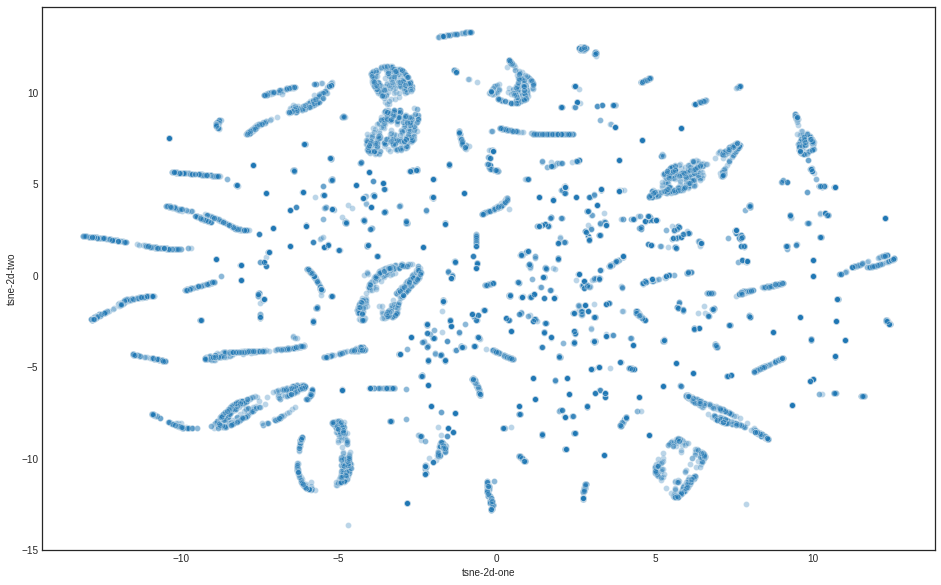

In [189]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

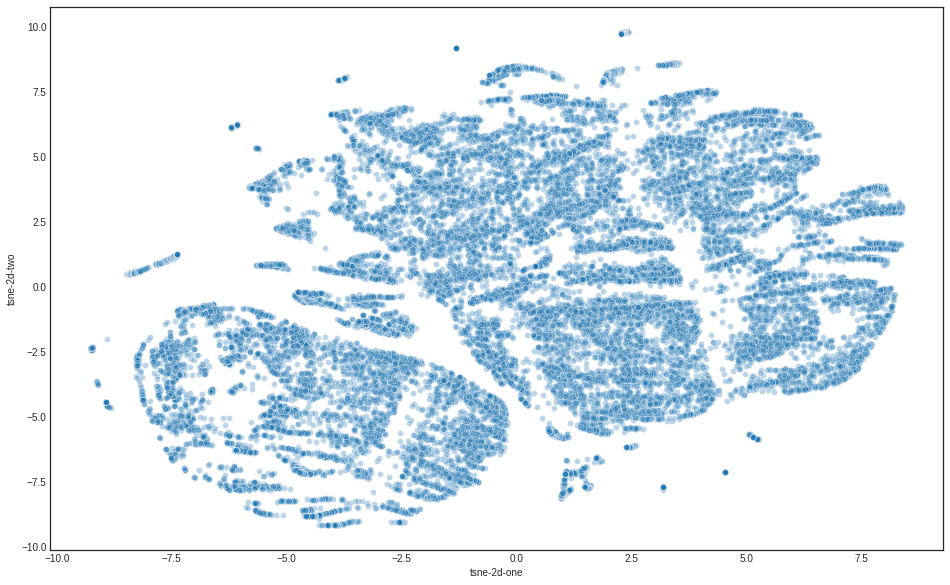

In [209]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(numeric_values)
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

> Through the tSNE visualization, I think one way we can improve our model's performance is do more feature engineering. Our data is divided into 3 groups somehow. 

In [197]:
X = min_max_scaler.fit_transform(train_df)
train_df_scaled = pd.DataFrame(X, columns=train_df.columns)

In [198]:
train_df_scaled['Predictions'] = y_hat.ravel()

In [199]:
train_df_scaled

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,count_date,Type_h,Type_t,Type_u,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,Predictions
0,0.133333,0.100765,0.232848,0.129857,0.111111,0.111111,0.001132,0.447031,0.613853,0.249177,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129997
1,0.066667,0.065497,0.232848,0.129857,0.111111,0.111111,0.000249,0.457755,0.615395,0.249177,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.066269
2,0.133333,0.130454,0.166320,0.016360,0.111111,0.055556,0.001171,0.406659,0.431369,0.291974,0.041879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.083008
3,0.133333,0.066667,0.174636,0.015337,0.111111,0.111111,0.000649,0.434919,0.400259,0.251078,0.041879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.084396
4,0.133333,0.084570,0.174636,0.015337,0.222222,0.111111,0.000695,0.439587,0.423025,0.251078,0.041879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27242,0.200000,0.061988,0.426195,0.768916,0.222222,0.111111,0.001194,0.721005,0.584948,0.365651,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.082085
27243,0.066667,0.058030,0.128898,0.015337,0.111111,0.055556,0.000497,0.452620,0.405874,0.041777,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.057800
27244,0.200

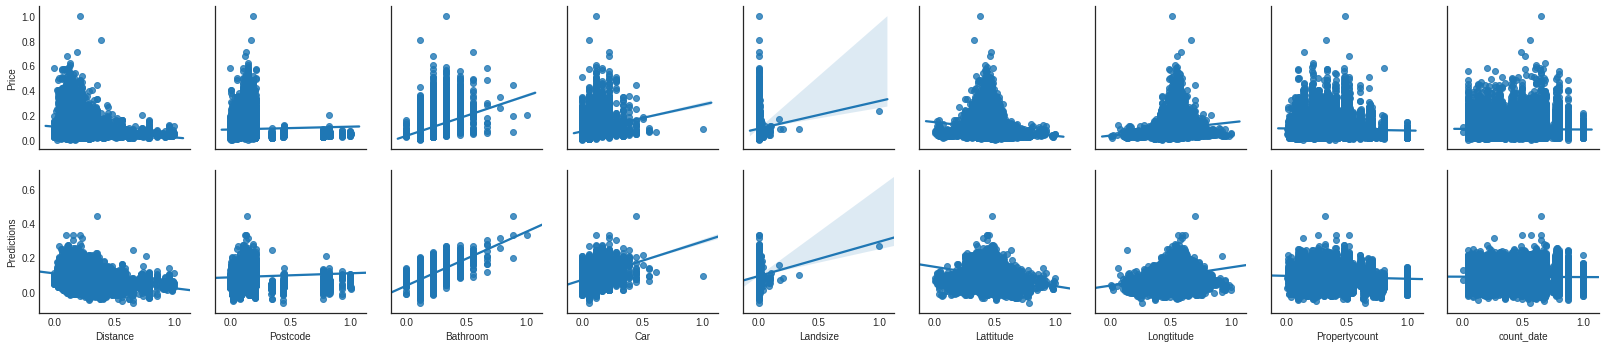

In [183]:
sns.pairplot(data=train_df_scaled, x_vars=['Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'Lattitude', 'Longtitude', 'Propertycount', 'count_date'], y_vars=['Price', 'Predictions'], kind='reg')

Seem like our feature engineering method (fill missing values with mean of each columns) made the Linear model predicts small value better but the performance get worse on predicting high values

### Visualize the residuals plot

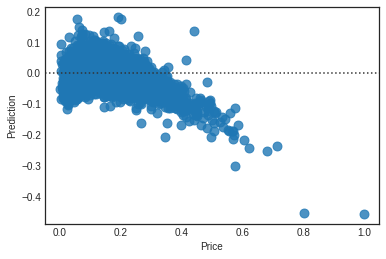

In [108]:
sns.residplot(x="Price", y="Prediction", data=pred_df, scatter_kws={"s": 80});

> The residuals plot shows that we have an underestimate hypothesis (more negative errors than positive errors)

> As the price go higher, the model's predictions get worse

### Visualize the distributions

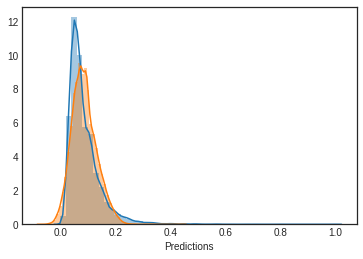

In [214]:
target_0 = train_df_scaled['Price']
target_1 = train_df_scaled['Predictions']

sns.distplot(target_0)
sns.distplot(target_1)

plt.show()


> "As the price go higher, the model's predictions get worse" because the model didn't recognize the pattern how a data points could get a high value for label (how a house get a very high cost)
